# Toy model (updated fidelity)

Has incorporated Remy's humidity (seasonal forcing

Can also run `toy_immunity_demo.py` (same code, just in script form, not notebook form). 

`ToyImmunitySubpopModel` follows these differential equations:

\begin{align*}
\frac{dS}{dt} &= \sigma^{R\rightarrow S} R(t) - \frac{\beta I(t)}{N} \frac{S(t)}{(1 + k^I M(t) + k^I_v M_v(t))} \\
\frac{dI}{dt} &= \frac{\beta I(t)}{N} \frac{S(t)}{(1 + k^I M(t) + k^I_v M_v(t))} - \gamma^{I\rightarrow H} \tilde{\pi}^{I \rightarrow H} \frac{I(t)}{(1 + k^H M(t) + k^H_v M_v(t))} - \gamma^{I \rightarrow R} (1 - \tilde{\pi}^{I \rightarrow H}) I(t) \\
\frac{dH}{dt} &= \gamma^{I\rightarrow H} \tilde{\pi}^{I \rightarrow H} \frac{I(t)}{(1 + k^H M(t) + k^H_v M_v(t))} - \gamma^{H \rightarrow R} H(t) \\
\frac{dR}{dt} &= \gamma^{I \rightarrow R} I(t) + \gamma^{H \rightarrow R} H(t) - \sigma^{R\rightarrow S} R(t) \\
\frac{dM}{dt} &= \frac{\sigma^{R \rightarrow S} R(t)}{N} \cdot (1 - o M(t) - o_v M_v(t)) - w M(t) \\
\frac{dM_v}{dt} &= \frac{V(t - \delta)}{N} - w_v M_v(t) \\
\end{align*}

where

- $N$: total number of people
- $\beta$: transmission rate (people per day)
- $\sigma^{R \rightarrow S}$:  rate at which people move from $R$ to $S$ (people per day) 
- $\gamma^{I \rightarrow R}$:  rate at which people move from $I$ to $R$ (people per day)
- $\gamma^{H \rightarrow R}$:  rate at which people move from $H$ to $R$ (people per day)
- $\tilde{\pi}^{I \rightarrow H}$: rate-adjusted proportion of infected individuals who get hospitalized
- $k^I$, $k^I_v$: "infection risk reduction" constants for $M$ and $M_v$ respectively
- $k^H$, $k^H_v$: "hospitalization risk reduction" constants for $M$ and $M_v$ respectively
- $w$, $w_v$: infection-induced immunity waning rate and vaccine-induced immunity waning rate respectively (derived from half-life of immunity antibodies -- antibodies per day?)
- $o$, $o_v$: immune saturation constants for $M$ and $M_v$ respectively -- used to create saturation or diminishing returns effect of additional infections (again, units/interpretation still unknown/unclear) -- we will get these values from Anass
- $V(t)$ is the number of people vaccinated on day $t$, and $\delta$ is the number of days it takes for the vaccine to be effective

# Important notes

- Remy has a question: for the $dI/dt$ equation, should the other appearance of $I(t)$ in the $I$ to $R$ transition also be scaled by $1/(1 + k^H M(t) + k^H_v M_v(t))$ to make the total outgoing flow from $I$ correct? He doesn't know. He also thinks we may be able to make this adjustment in the $k$-values.
- Currently in this toy model code, we have $V(t)$ constant (see parameter `daily_vaccines_constant` in `params` dict)

In [1]:
###########################################################
######################## IMPORTS ##########################
###########################################################

from pathlib import Path
import numpy as np
import pandas as pd

import sys
import os

notebook_dir = os.getcwd() 
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))  
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import city-level transmission base components module
import clt_base as clt

# Import flu model module, which contains customized subclasses
import toy_immunity_core as imm

In [2]:
###########################################################
################# READ INPUT FILES ########################
###########################################################

# Obtain path to folder with JSON input files
base_path = Path().parent / "toy_immunity_input_files"

# Get filepaths for initial values of compartments and epi metrics, fixed parameters,
#   configuration, and travel proportions
compartments_epi_metrics_init_vals_filepath = base_path / "compartments_epi_metrics_init_vals.json"
params_filepath = base_path / "params.json"
config_filepath = base_path / "config.json"

# Read in files as dictionaries and dataframes
# Note that we can also create these dictionaries directly
#   rather than reading from a predefined input data file
compartments_epi_metrics_dict = \
    clt.load_json_new_dict(compartments_epi_metrics_init_vals_filepath)
params_dict = clt.load_json_new_dict(params_filepath)
config_dict = clt.load_json_new_dict(config_filepath)

humidity_filepath = base_path / "humidity_austin_2023_2024.csv"

# Create two independent bit generators
bit_generator = np.random.MT19937(88888)
jumped_bit_generator = bit_generator.jumped(1)

In [3]:
# Parameter variable names and default values

for key, value in params_dict.items():
    print(key, value)

num_age_groups 1
num_risk_groups 1
beta 1.5
humidity_impact 0.1
I_to_H_rate 0.5
I_to_R_rate 0.25
H_to_R_rate 0.1
R_to_S_rate 0.02
I_to_H_adjusted_prop 0.1
inf_induced_saturation 0.7
inf_induced_immune_wane 0.0002
vax_induced_saturation 0.2
vax_induced_immune_wane 0.004
inf_induced_inf_risk_reduce 4
inf_induced_hosp_risk_reduce 4
vax_induced_inf_risk_reduce 1.5
vax_induced_hosp_risk_reduce 1.5
daily_vaccines_constant 100


In [4]:

###########################################################
############# CREATE SUBPOPULATION MODELS #################
###########################################################

# Create two subpopulation models, one for the north
#   side of the city and one for the south side of the city
# In this case, these two (toy) subpopulations have the
#   same demographics, initial compartment and epi metric values,
#   fixed parameters, and school-work calendar.
# If we wanted the "north" subpopulation and "south"
#   subpopulation to have different aforementioned values,
#   we could read in two separate sets of files -- one
#   for each subpopulation
model = imm.ToyImmunitySubpopModel(compartments_epi_metrics_dict,
                                   params_dict,
                                   config_dict,
                                   np.random.Generator(bit_generator),
                                   humidity_filepath,
                                  "demo_model")

model.simulate_until_day(300)

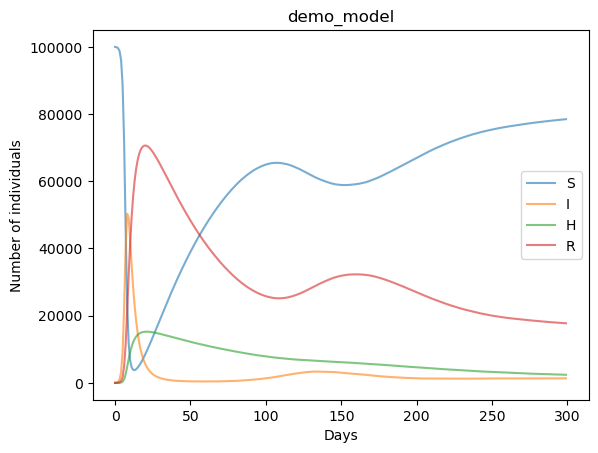

In [5]:
clt.plot_subpop_basic_compartment_history(model)

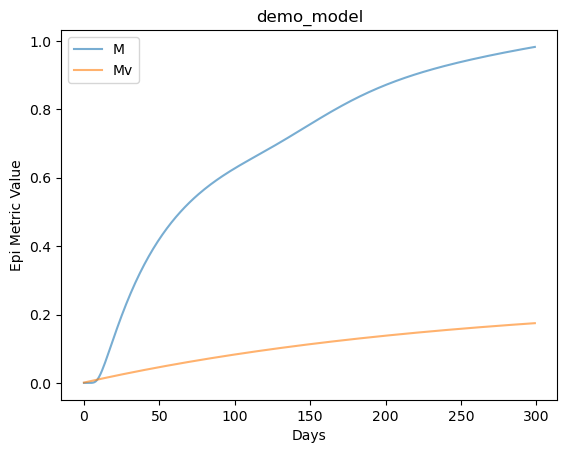

In [6]:
clt.plot_subpop_epi_metrics(model)

<Figure size 640x480 with 0 Axes>

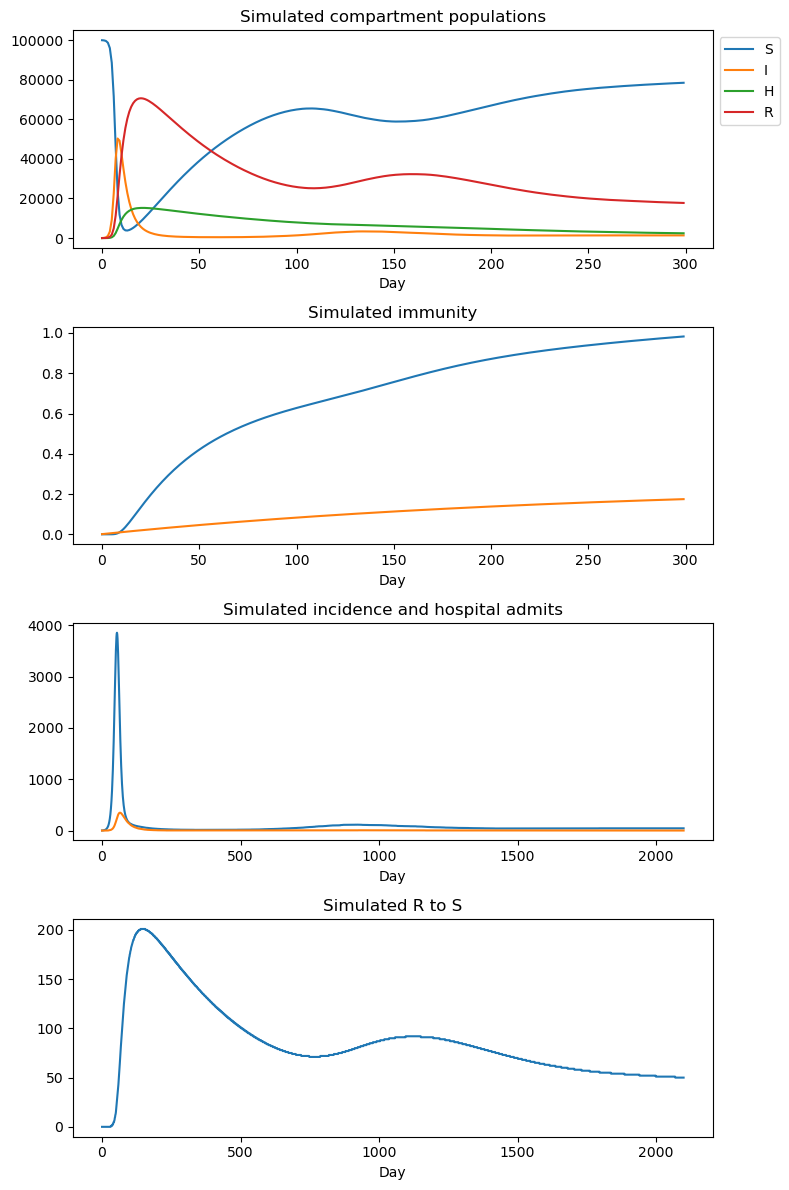

In [7]:
imm.make_graph_set(model)

<Figure size 640x480 with 0 Axes>

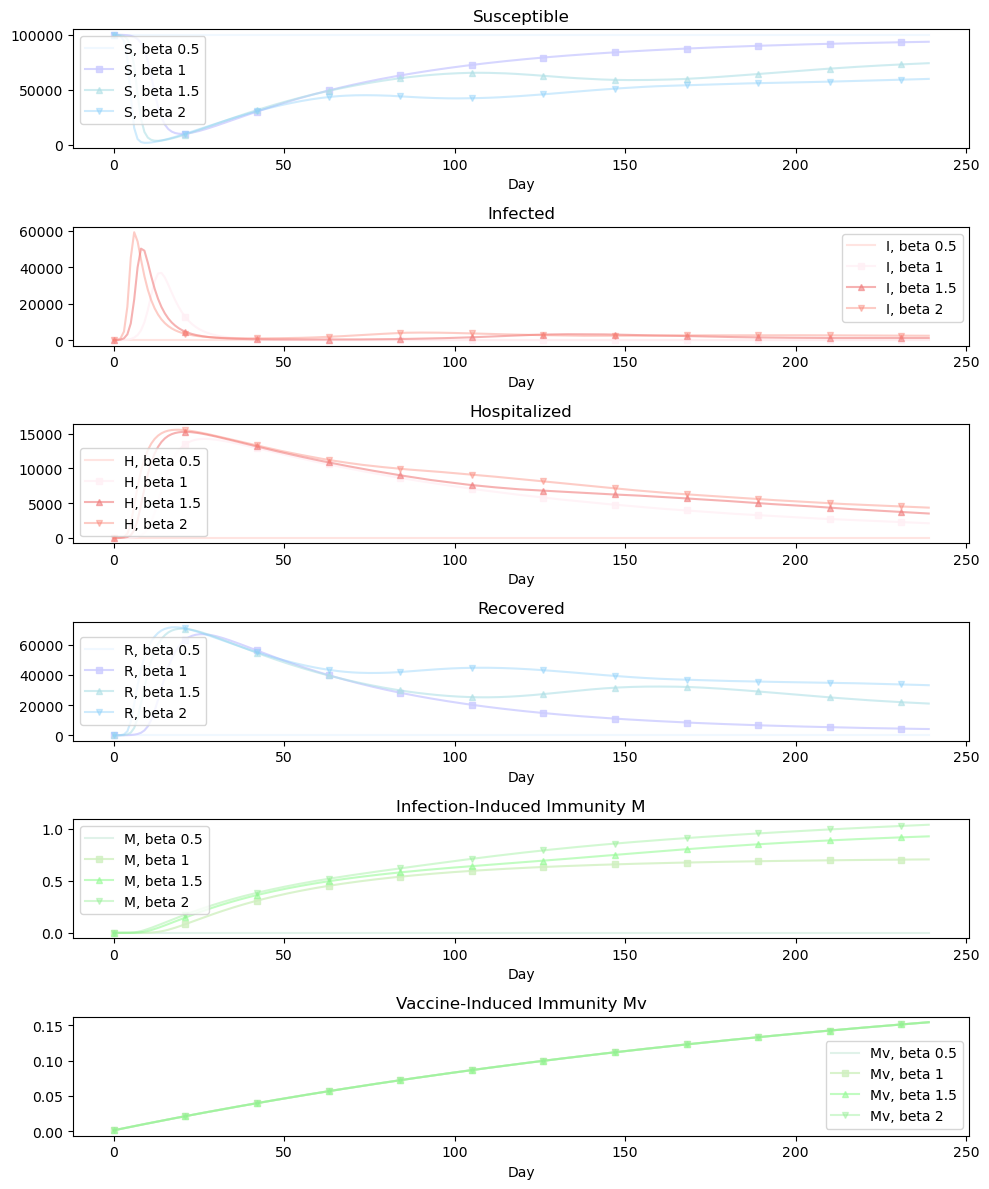

In [8]:
imm.changing_param_val_graph(model, "param", "beta", [0.5, 1, 1.5, 2])